In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import h5py

from numba import jit
from mpi4py import MPI

from CommonModules.input_data import InputData 
from CommonModules.PlasmaEquilibrium import TokamakEquilibrium
import RayTracing.modules.dispersion_matrix_cfunctions as disp
import CommonModules.physics_constants as phys

eps = np.finfo(np.float32).eps

In [2]:
# electron mass
m_e         = 9.10938356e-31 # kg
# speed of light
c           = 299792458 # m/s
# electron charge
e           = 1.60217662e-19 # C
# momentum conversion
e_over_me_c2 = e / (m_e * c**2) 

In [3]:
def read_h5file(filename):
    """
    Read the h5 file and return the data
    """
    file            = h5py.File(filename, 'r')

    print('Keys:', list(file.keys()))

    WhatToResolve   = file.get('WhatToResolve')[()]
    FreqGHz         = file.get('FreqGHz')[()]
    mode            = file.get('Mode')[()]
    Wfct            = file.get('BinnedTraces')[()]
    try:
        Absorption = file.get('Absorption')[()]
    except:
        Absorption = None

    try:
        EnergyFlux = file.get('VelocityField')[()]

    except:
        EnergyFlux = None

    
    rhomin          = file.get('rhomin')[()]
    rhomax          = file.get('rhomax')[()]
    nmbrrho         = file.get('nmbrrho')[()]
    rho             = np.linspace(rhomin, rhomax, nmbrrho)

    Thetamin        = file.get('Thetamin')[()]
    Thetamax       = file.get('Thetamax')[()]
    nmbrTheta        = file.get('nmbrTheta')[()]
    Theta           = np.linspace(Thetamin, Thetamax, nmbrTheta)

    Nparallelmin    = file.get('Nparallelmin')[()]
    Nparallelmax    = file.get('Nparallelmax')[()]
    nmbrNparallel   = file.get('nmbrNparallel')[()]
    Nparallel      = np.linspace(Nparallelmin, Nparallelmax, nmbrNparallel)

    Nperpmin        = file.get('Nperpmin')[()]
    Nperpmax        = file.get('Nperpmax')[()]
    nmbrNperp       = file.get('nmbrNperp')[()]
    Nperp          = np.linspace(Nperpmin, Nperpmax, nmbrNperp)

    print('WhatToResolve:', WhatToResolve)
    print('FreqGHz:', FreqGHz)
    print('mode:', mode)
    file.close()

    return WhatToResolve, FreqGHz, mode, Wfct, Absorption, EnergyFlux, rho, Theta, Nparallel, Nperp

In [4]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize, fsolve

import CommonModules.BiSplineDer as bispl

def config_quantities(psi, theta, omega, Eq):

    ptR, ptZ = np.zeros([len(psi), len(theta)]), np.zeros([len(psi), len(theta)])
    ptBt = np.zeros_like(ptR)
    ptBR = np.zeros_like(ptR)
    ptBz = np.zeros_like(ptR)
    ptB = np.zeros_like(ptR)
    ptNe = np.zeros_like(ptR)
    ptTe = np.zeros_like(ptR)

    P, X, R, L, S = np.zeros_like(ptR), np.zeros_like(ptR), np.zeros_like(ptR), np.zeros_like(ptR), np.zeros_like(ptR)

    for l, psi_l in enumerate(psi):
        for t, theta_t in enumerate(theta):
            ptR[l, t], ptZ[l, t] = Eq.flux_to_grid_coord(psi_l, theta_t)

            ptNe[l, t] = Eq.NeInt.eval(ptR[l, t], ptZ[l, t])
            ptTe[l, t] = Eq.TeInt.eval(ptR[l, t], ptZ[l, t])

            ptBt[l, t] = Eq.BtInt.eval(ptR[l, t], ptZ[l, t])
            ptBR[l, t] = Eq.BRInt.eval(ptR[l, t], ptZ[l, t])
            ptBz[l, t] = Eq.BzInt.eval(ptR[l, t], ptZ[l, t])

            ptB[l, t] = np.sqrt(ptBt[l, t]**2 + ptBR[l, t]**2 + ptBz[l, t]**2)

            omega_pe = disp.disParamomegaP(ptNe[l, t])
            omega_ce = disp.disParamOmega(ptB[l, t])

            P[l, t] = 1 - omega_pe**2 / (omega**2)
            X[l, t] = omega_ce / omega

            R[l, t] = (P[l, t] + X[l, t])/(1 + X[l, t])
            L[l, t] = (P[l, t] - X[l, t])/(1 - X[l, t])
            S[l, t] = .5 * (R[l, t] + L[l, t])

    return ptR, ptZ, ptBt, ptBR, ptBz, ptB, ptNe, ptTe, P, X, R, L, S


def minmaxB(psi, BInt, theta):

    # Find B(theta) at the requested psi
    B_at_psi = np.array([BInt.eval(psi, theta) for theta in theta])
    B_at_psiInt = interp1d(theta, B_at_psi, kind='cubic')

    minusB_at_psi = np.array([-BInt.eval(psi, theta) for theta in theta])
    minusB_at_psiInt = interp1d(theta, minusB_at_psi, kind='cubic')

    minimum = minimize(B_at_psiInt, 0.)
    maximum = minimize(minusB_at_psiInt, -3)

    # Return the interpolated function, the minimum and maximum

    return B_at_psiInt, B_at_psiInt(minimum.x), B_at_psiInt(maximum.x)


# Function to calculate the quantities related to trapping.
#   - B_bounce(psi, ksi0): at what field a particle will bounce
#   - Ksi_trapping(psi): The boundary value for given psi. Particles with smaller ksi will be trapped
#   - theta_T,m and theta_T,M(psi,ksi0): minimal and maximal angle reached by particles (where they meet B_bounce)


def Trapping_boundary(psi, ksi, BInt, theta_grid=[], eps = np.finfo(np.float32).eps):
    TrapB = np.zeros((len(psi), len(ksi)))
    Trapksi = np.zeros_like(psi)
    theta_roots = np.zeros((len(psi), len(ksi), 2))


    for i, psi_val in enumerate(psi):
        B_at_psiInt, B0, Bmax = minmaxB(psi_val, BInt, theta_grid)
        TrapB[i] = B0/(1-ksi**2 + eps)
        Trapksi[i] = np.sqrt(1-B0/Bmax)

        for j, ksi_val in enumerate(ksi):
            if abs(ksi_val) <= Trapksi[i]:
                def deltaB(x):
                    return B_at_psiInt(x) - TrapB[i, j]

                theta_roots[i, j] = fsolve(deltaB, [-np.pi/2, np.pi/2])
            else:
                theta_roots[i, j, 0] = -np.pi
                theta_roots[i, j, 1] = np.pi

    return TrapB, Trapksi, theta_roots


In [5]:
def pTe_from_Te(Te):
    """
    Thermal momentum from temperature, normalised to m_e*c
    Te in keV
    factor e/(m_e*c**2) is precalculated
    """
    return np.sqrt(1e3 * Te* e_over_me_c2)

def gamma(p, pTe):
    """
    Relativistic factor, for p a grid of momenta, normalized to the thermal momentum.
    pTe is the thermal momentum, normalised to m_e*c itself, making the calculation easy
    """
    return np.sqrt(1 + (p*pTe)**2)

def N_par_resonant(inv_kp, p_Te, Gamma, X, harm, eps):
    """
    Calculate the resonant n_par. P_norm, Ksi and Gamma are of shape (n_p x n_ksi), StixY is a scalar.
    Returns a matrix of the same shape as P_norm.
    """
    return (Gamma - harm*X)/p_Te *inv_kp

def polarisation(N2, K_angle, P, R, L, S):
    PlusOverMinus = (N2 - R)/(N2 - L)
    ParOverMinus = - (N2 - S)/(N2 - L) * (N2*np.cos(K_angle)*np.sin(K_angle))/(P - N2*np.sin(K_angle)**2)

    emin2 = 1/(1 + PlusOverMinus**2 + ParOverMinus**2)
    eplus2 = PlusOverMinus**2 * emin2
    epar2 = ParOverMinus**2 * emin2

    return np.array([eplus2, emin2, epar2])

@jit(nopython=True)
def A_perp(nperp, p_norm, pTe, ksi, X):
    return nperp * p_norm * pTe * np.sqrt(1-ksi**2) * X

# Import the bessel functions
import scipy.special as sp

def bessel_integrand(n, x):
    return sp.jn(n, x)**2

In [6]:
def D_RF_prefactor(p_norm, ksi, Ne, Te, omega, eps):
    omega_pe = disp.disParamomegaP(Ne)
    p_Te = pTe_from_Te(Te)
    Gamma_Te = gamma(1, p_Te)
    v_Te = p_Te / Gamma_Te / m_e
    coulomb_log = 25.2 - 0.5 * np.log(Ne) + np.log(Te) # Probably wrong, right now DKE 6.50 with n_e* in 1e19 m⁻3 and T_e in keV

    P_norm, Ksi = np.meshgrid(p_norm, ksi)
    Gamma = gamma(P_norm, p_Te)
    inv_kabsp = 1 / (abs(Ksi) * P_norm + eps)

    prefac =  2 * (c/omega)**4 * Gamma * inv_kabsp * v_Te / (omega_pe**2 * coulomb_log * Gamma_Te**2)

    return prefac.T

def D_RF_nobounce(p_norm, ksi, npar, nperp, Wfct, Te, P, X, R, L, S, n, eps, plot=False):
        
    # The subfunction, that for a given psi_l and theta_t, calculated the 
    # contribution to D_RF for a given momentum grid.
    # This is done for all harmonics in n.

    npar_tree = KDTree(npar.reshape(-1, 1))
    d_npar = npar[1] - npar[0] # Assume a constant grid for now
    


    # 2D momentum grid, already filtered out
    P_norm, Ksi = np.meshgrid(p_norm, ksi)


    # Precalculate the inverse ksi*p_norm grid, with a small offset to avoid division by zero

    inv_kp = 1 / (Ksi * P_norm + eps)
    # TO BE REMOVED, place an upper bound on this to see things clearly
    #inv_kp = np.minimum(inv_kp, 5)


            
    # Calculate the relativistic factor, given the thermal momentum at this location
    p_Te = pTe_from_Te(Te)
    Gamma = gamma(P_norm, p_Te)

    # Initialise the integrand

    D_RF_integrand = np.zeros((len(p_norm), len(ksi)))



    for harm in n:
        # resonance_N_par gives a 2D array with the same shape as P_norm and Ksi
        # This whole calculation is done dimensionless now. 

        resonance_N_par = N_par_resonant(inv_kp, p_Te, Gamma, X, harm, eps)

        # We can now query the KDTree to get the indices of the resonant values in Npar.
        # The code below efficiently looks for the index of the value in Npar that is closest to the resonant value.
        # This is done for every point in the grid. If it is not within dNpar/2 of any value in Npar, the index is set to -1.
        # This in fact replaces the integral over Npar, as we now just have a 2D array indicating what value of Npar is resonant, if any.

        dist_N_par, ind_N_par = npar_tree.query(np.expand_dims(resonance_N_par, axis=-1), distance_upper_bound=d_npar/2) #/2
        res_condition_N_par = np.where(np.isinf(dist_N_par), -1, ind_N_par)

        if plot:
            fig = plt.figure()

            P_par, P_perp = P_norm * Ksi, P_norm * np.sqrt(1 - Ksi**2)

            pl = plt.contour(P_par, P_perp, resonance_N_par, levels=np.linspace(-1, 1, 11), cmap='coolwarm')
            if np.any(res_condition_N_par == -1):
                norescon = plt.contour(P_par, P_perp, res_condition_N_par, colors='k', levels=[-1])
            rescon = plt.contourf(P_par, P_perp, res_condition_N_par, cmap='Greens', levels=np.arange(0, len(Npar)))
            plt.clabel(pl, inline=True, fontsize=8)
            plt.colorbar(rescon, label='Npar index')
            plt.xlabel(r'$p_\|/p_{Te}$')
            plt.ylabel(r'$p_\perp/_{Te}$')

        
        res_mask_Pspace = np.where(res_condition_N_par != -1, True, False) # Mask for the resonant values in P_norm and Ksi
 
        j_res, i_res = np.where(res_mask_Pspace) # Tuple containing 2 arrays.
        # The first array contains the indices of the resonant values in Ksi, the second in P_norm

        # We can now use the mask to select the resonant values in P_norm and Ksi, and calculate the integrand. 
        # Where there is no Npar value resonant, we can skip the calculation.

        for j, i in zip(j_res, i_res):

            i_npar = res_condition_N_par[j, i]
            # At this point, we check |E|² to see if at Npar[i_npar] (for this P,Ksi), the beam is present.
            # And if so, for what value of Nperp.

            mask_beam_present = Wfct[i_npar, :] > 0 
            indeces_Nperp_beam_present = np.where(mask_beam_present)[0]


            if np.any(mask_beam_present):

                # Calculate the polarisation for the cells where the beam is present
                # Now that we've pruned all the data so heavily, finally we can calculate the polarisation for the beam cells.
                
                for i_nperp in indeces_Nperp_beam_present:
                    # Calculate local quantities
                    N2 = nperp[i_nperp]**2 + npar[i_npar]**2
                    K_angle = np.arctan2(npar[i_npar], nperp[i_nperp])
                    pol = polarisation(N2, K_angle, P, R, L, S)

                    a_perp = A_perp(nperp[i_nperp], P_norm[j, i], p_Te, Ksi[j, i], X)

                    #Take the bessel functions...
                    #
                    #And combine to get polarisation term
                    #
                    Pol_term = .5* (pol[0] * bessel_integrand(harm-1, a_perp) + \
                                    pol[1] * bessel_integrand(harm+1, a_perp) )+ \
                                        pol[2] * bessel_integrand(harm, a_perp)
                    
                    # Now we can calculate the integrand for this point in the grid

                    D_RF_integrand[i, j] += nperp[i_nperp] * Pol_term * Wfct[i_npar, i_nperp]
    return D_RF_integrand
                

def D_RF_at_T(theta, p_norm, ksi, npar, nperp, Trapksi, theta_T, Wfct, Te, P, XInt, RInt, LInt, SInt, n):

    D_RF_at_trapping = np.zeros((len(p_norm), len(ksi), 2))
    indices_m = np.zeros(len(ksi))
    indices_M = np.zeros(len(ksi))

    for j, ksi_val in enumerate(ksi):
        if abs(ksi_val) < Trapksi:
            # We have to calculate the D_RF_nobounce matrix for this point
            # If it was larger than the trapping boundary, we can skip this calculation because it's passing
            
            # Interpolate all needed quatities to the two trapping boundaries
            # Te and Te stay the same though.

            X_m, X_M = XInt(theta_T[j, 0]), XInt(theta_T[j, 1])
            R_m, R_M = RInt(theta_T[j, 0]), RInt(theta_T[j, 1])
            L_m, L_M = LInt(theta_T[j, 0]), LInt(theta_T[j, 1])
            S_m, S_M = SInt(theta_T[j, 0]), SInt(theta_T[j, 1])

            # Find the index of the theta value just below and just above the bounce point
            theta_below_m = np.where(theta_T[j, 0] >  theta, True, False)
            theta_above_M = np.where(theta_T[j, 1] <  theta, True, False)

            ind_m = np.where(theta_below_m)[0][-1]
            ind_M = np.where(theta_above_M)[0][0]
            indices_m[j] = ind_m
            indices_M[j] = ind_M

            # Calculate the weights for the interpolation of Wfct.
            # The only one to be done manually, as it is multidimensional
            A_m = (theta_T[j,0] - theta[ind_m])/(theta[ind_m+1] - theta[ind_m])
            A_M = (theta_T[j,1] - theta[ind_M-1])/(theta[ind_M] - theta[ind_M-1])
            B_m = (theta[ind_m+1] - theta_T[j,0])/(theta[ind_m+1] - theta[ind_m])
            B_M = (theta[ind_M] - theta_T[j,1])/(theta[ind_M] - theta[ind_M-1])

            Wfct_m = A_m * Wfct[ind_m+1, :,:] + B_m * Wfct[ind_m, :,:]
            Wfct_M = A_M * Wfct[ind_M, :,:] + B_M * Wfct[ind_M-1, :,:]

            D_RF_at_trapping[:, j, 0] = D_RF_nobounce(p_norm, [ksi_val], npar, nperp, \
                            Wfct_m, Te, \
                            P, X_m, R_m, L_m, S_m, n, eps)[:, 0]
            D_RF_at_trapping[:, j, 1] = D_RF_nobounce(p_norm, [ksi_val], npar, nperp, \
                            Wfct_M, Te, \
                            P, X_M, R_M, L_M, S_M, n, eps)[:, 0]
        else:
            D_RF_at_trapping[:, j] = np.nan
            indices_m[j] = np.nan
            indices_M[j] = np.nan

    return D_RF_at_trapping, indices_m, indices_M

def bounce_sum(d_theta_grid_j, CB_j, Func, passing, sigma_dep=False):
    if passing or not sigma_dep:
        # Even if it is trapped, when there's no explicit sigma dependence, we can just sum over the grid
        # Instead of summing over both signs of ksi
        return np.sum(d_theta_grid_j/(2*np.pi) * CB_j * Func)
    else:
        return 1/2* (np.sum(d_theta_grid_j/(2*np.pi) * CB_j * Func) + np.sum(d_theta_grid_j/(2*np.pi) * CB_j * -Func))


                    

# Final function

In [10]:
def D_RF(psi, theta, p_norm_w, ksi_w, npar, nperp, Wfct, Eq, n=[2, 3], FreqGHz=82.7, eps=np.finfo(np.float32).eps):

    """
    The main function to calculate the RF diffusion coefficients.
    It takes in the following arguments:

        psi: np.array [l]
            The radial coordinate 
        theta: np.array [t]
            The poloidal coordinate
        p_norm_w: np.array [i]
            The normalised momentum grid (whole grid)
        ksi_w: np.array [j]
            The pitch angle grid (whole grid)
        npar: np.array [length given by WKBeam binning]
            The parallel refractive index
        nperp: np.array [length given by WKBeam binning]
            The perpendicular refractive index
        Wfct: np.array [l, t, npar, nperp, 2]
            The electric power density in [J/m^3] from WKbeam
        Eq: equilibrium object
            The equilibrium object, containing the equilibrium quantities
            From WKBeam too
        n: list of harmonics to take into account
        FreqGHZ: float [GHZ]

    Returns:
    
            DRF0_wh: np.array [l, i_w, j_h]
                The FP diffusion coefficient D_RF0 on the whole-half grid
            DRF0D_wh: np.array [l, i_w, j_h]
                The DKE diffusion coefficient D_RF0D on the whole-half grid
            DRF0F_wh: np.array [l, i_w, j_h]
                The DKE convection coefficient D_RF0F on the whole-half grid
            DRF0_hw: np.array [l, i_h, j_w] 
                The FP diffusion coefficient D_RF0 on the half-whole grid
            DRF0D_hw: np.array [l, i_h, j_w]
                The DKE diffusion coefficient D_RF0D on the half-whole grid
            DRF0F_hw: np.array [l, i_h, j_w]
                The DKE convection coefficient D_RF0F on the half-whole grid
            DRF0_hh: np.array [l, i_h, j_h]
                The FP diffusion coefficient D_RF0 on the half-half grid
            DRF0D_hh: np.array [l, i_h, j_h]
                The DKE diffusion coefficient D_RF0D on the half-half grid
    """
    #---------------------------------#
    #---Calculate the quantities needed for the calculation---#
    #---------------------------------#

    omega = phys.AngularFrequency(FreqGHz)

    # Calculate the normalised momentum and pitch angle on the half grid
    p_norm_h = 0.5 * (p_norm_w[1:] + p_norm_w[:-1])
    ksi_h = 0.5 * (ksi_w[1:] + ksi_w[:-1])

    # widths of half grid are easy. Only defined in the proper region
    d_p_norm_h = np.diff(p_norm_w)
    d_ksi_h = np.diff(ksi_w)

    # Vice versa, calculate the full grid widths. Bit more annoying, as the contributions of edge points
    # are smaller, given that the full grid points define box edges
    d_p_norm_w = np.concatenate(([d_p_norm_h[0]/2], np.diff(p_norm_h), [d_p_norm_h[-1]/2]))
    d_ksi_w = np.concatenate(([d_ksi_h[0]/2], np.diff(ksi_h), [d_ksi_h[-1]/2]))
    
    # For psi and theta. Psi is a half grid already, theta is a full grid
    d_psi = 1/2* (np.diff(psi)[:-1] + np.diff(psi)[1:])
    d_psi = np.concatenate(([np.diff(psi)[0]], d_psi, [np.diff(psi)[-1]]))
    d_theta = 1/2* (np.diff(theta)[:-1] + np.diff(theta)[1:])
    d_theta = np.concatenate(([np.diff(theta)[0]/2], d_theta, [np.diff(theta)[-1]/2]))

    # Precalculate quantities in configuration space
    Rp, Zp = Eq.magn_axis_coord_Rz
    ptR, ptZ, ptBt, ptBR, ptBz, ptB, ptNe, ptTe, P, X, R, L, S = config_quantities(psi, theta, omega, Eq)


    # Trapping boundaries on psi, ksi grids
    ptB_Int = bispl.BiSpline(psi, theta, ptB)

    # Trapksi [l, -], theta_T [l, j, 2]
    _, Trapksi_w, theta_T_w = Trapping_boundary(psi, ksi_w, ptB_Int, theta)
    _, Trapksi_h, theta_T_h = Trapping_boundary(psi, ksi_h, ptB_Int, theta)

    #--------------------------------#
    #---Initialision of grids---#
    #--------------------------------#

    # The Dr_nobounce matrices on the three grids
    # [l, t, i, j]
    D_rf_nobounce_wh = np.zeros((len(psi), len(theta), len(p_norm_w), len(ksi_h)))
    D_rf_nobounce_hw = np.zeros((len(psi), len(theta), len(p_norm_h), len(ksi_w)))
    D_rf_nobounce_hh = np.zeros((len(psi), len(theta), len(p_norm_h), len(ksi_h)))

    # Initialise the final 8 matrices, the D_RF matrices [l, i, j]
    # Also the lambda*q matrices [l, j]
    lambda_q_h = np.zeros((len(psi), len(ksi_h)))
    lambda_q_w = np.zeros((len(psi), len(ksi_w)))
                          
    DRF0_wh = np.zeros((len(psi), len(p_norm_w), len(ksi_h)))
    DRF0D_wh = np.zeros((len(psi), len(p_norm_w), len(ksi_h)))
    DRF0F_wh = np.zeros((len(psi), len(p_norm_w), len(ksi_h)))

    DRF0_hw = np.zeros((len(psi), len(p_norm_h), len(ksi_w)))
    DRF0D_hw = np.zeros((len(psi), len(p_norm_h), len(ksi_w)))
    DRF0F_hw = np.zeros((len(psi), len(p_norm_h), len(ksi_w)))

    DRF0_hh = np.zeros((len(psi), len(p_norm_h), len(ksi_h)))
    DRF0D_hh = np.zeros((len(psi), len(p_norm_h), len(ksi_h)))

    #--------------------------------#
    # ---Calculation split into the psi grid---#
    #--------------------------------#

    for l, psi_l in enumerate(psi):
        # The calculation is split completely into the psi grid,
        # as the calculation is independent for every psi value

        # First find the normalisation prefactor for the D_RF matrices [i, j]
        C_RF_wh =  D_RF_prefactor(p_norm_w, ksi_h, ptNe[l, 0], ptTe[l, 0], omega, eps)
        C_RF_hw =  D_RF_prefactor(p_norm_h, ksi_w, ptNe[l, 0], ptTe[l, 0], omega, eps)
        C_RF_hh =  D_RF_prefactor(p_norm_h, ksi_h, ptNe[l, 0], ptTe[l, 0], omega, eps)


        #--------------------------------#
        #---Caculation of the D_RF_nobounce matrices---#
        #--------------------------------#

        # This is the expensive part, where the resonance condition is calculated


        for t, theta_t in enumerate(theta):
            
            # Check if there is actualy beam power at this location
            if np.sum(Wfct[l, t, :,:, 0]) == 0:
                continue
            
            # First get a mask in ksi, for what particles can access this angle
            if theta_t < 0:
                # Need to check the lower boundary
                ksi_w_mask = theta_T_w[l,:, 0] < theta_t
                ksi_h_mask = theta_T_h[l,:, 0] < theta_t
            else:
                # Need to check the upper boundary
                ksi_w_mask = theta_T_w[l,:, 1] > theta_t
                ksi_h_mask = theta_T_h[l,:, 1] > theta_t

            # Now that we know what ksi values are accessible,
            # we create the momentum grids for this theta value
            ksi_w_masked = ksi_w[ksi_w_mask]
            ksi_h_masked = ksi_h[ksi_h_mask]

            # Then we can calculate the D_RF_nobounce matrices
            D_rf_nobounce_wh[l, t, :, ksi_h_mask] = \
                D_RF_nobounce(p_norm_w, ksi_h_masked, npar, nperp, \
                              Wfct[l, t, :,:, 0], ptTe[l, t], \
                                P[l, t], X[l, t], R[l, t], L[l, t], S[l, t], n, eps).T
            D_rf_nobounce_hw[l, t, :, ksi_w_mask] = \
                D_RF_nobounce(p_norm_h, ksi_w_masked, npar, nperp, \
                              Wfct[l, t, :,:, 0], ptTe[l, t], \
                                P[l, t], X[l, t], R[l, t], L[l, t], S[l, t], n, eps).T
            D_rf_nobounce_hh[l, t, :, ksi_h_mask] = \
                D_RF_nobounce(p_norm_h, ksi_h_masked, npar, nperp, \
                              Wfct[l, t, :,:, 0], ptTe[l, t], \
                                P[l, t], X[l, t], R[l, t], L[l, t], S[l, t], n, eps).T


        #--------------------------------#
        #---Calculation at trapping boundaries---#
        #--------------------------------#

        # This whole calculation was only on the regular theta grid however.
        # The contributions to the bounce integral from near the bounce points are very important and should be included!
        # For every ksi value at this psi, we have different trapping boundaries, 
        # and we need to calculate the D_RF_nobounce matrices for these points too.

        XInt = interp1d(theta, X[l, :])
        RInt = interp1d(theta, R[l, :])
        LInt = interp1d(theta, L[l, :])
        SInt = interp1d(theta, S[l, :])

        D_RF_nobounce_wh_at_T, indices_m_h, indices_M_h = D_RF_at_T(theta, p_norm_w, ksi_h, npar, nperp, Trapksi_h[l], \
                                            theta_T_h[l], Wfct[l, :, :, :, 0], ptTe[l, 0], P[l, 0], XInt, RInt, LInt, SInt, n)
        D_RF_nobounce_hw_at_T, indices_m_w, indices_M_w = D_RF_at_T(theta, p_norm_h, ksi_w, npar, nperp, Trapksi_w[l], \
                                            theta_T_w[l], Wfct[l, :, :, :, 0], ptTe[l, 0], P[l, 0], XInt, RInt, LInt, SInt, n)
        D_RF_nobounce_hh_at_T, _, _= D_RF_at_T(theta, p_norm_h, ksi_h, npar, nperp, Trapksi_h[l], \
                                            theta_T_h[l], Wfct[l, :, :, :, 0], ptTe[l, 0], P[l, 0], XInt, RInt, LInt, SInt, n)

        
        # Give them an extra first dimension, for the theta value [1, i, j, 2]
        D_RF_nobounce_wh_at_T = np.expand_dims(D_RF_nobounce_wh_at_T, 0)
        D_RF_nobounce_hw_at_T = np.expand_dims(D_RF_nobounce_hw_at_T, 0)
        D_RF_nobounce_hh_at_T = np.expand_dims(D_RF_nobounce_hh_at_T, 0)

        #--------------------------------#
        #---Bounce average calculation---#
        #--------------------------------#

        # As the trapping boundaries for given psi depend on ksi,
        # the bounce averaging is done for the half and whole grids separately

        # First for the half ksi grid (wh, hh)

        for j, ksi_val in enumerate(ksi_h):

            if np.isnan(indices_m_h[j]):
                # Not trapped, theta grid for bounce averaging is the full one
                passing = True

                theta_grid_j_h = theta
                d_theta_grid_j_h = d_theta
                
                _, B0_h, _            = minmaxB(psi_l, ptB_Int, theta_grid_j_h)
                B_at_psi_j_h          = ptB[l, :]
                BR_at_psi_j_h         = ptBR[l, :]
                Bz_at_psi_j_h         = ptBz[l, :]
                R_axis_at_psi_j_h     = ptR[l, :] - Rp
                Z_axis_at_psi_j_h     = ptZ[l, :] - Zp

                D_rf_lj_wh = D_rf_nobounce_wh[l, :, :, j]
                D_rf_lj_hh = D_rf_nobounce_hh[l, :, :, j]
                
            else:
                # Trapped, theta grid is the one from the bounce point to the bounce point
                passing = False

                # Add the trapped points to the theta grid
                theta_aux = theta[int(indices_m_h[j]+1):int(indices_M_h[j])-1]
                theta_grid_j_h = np.concatenate(([theta_T_h[l, j, 0]], theta_aux, [theta_T_h[l, j, 1]]))
                # Get the grid spacing as well
                d_theta_grid_j_h = 1/2* (np.diff(theta_grid_j_h)[:-1] + np.diff(theta_grid_j_h)[1:])
                d_theta_grid_j_h = np.concatenate(([np.diff(theta_grid_j_h)[0]/2], d_theta_grid_j_h, [np.diff(theta_grid_j_h)[-1]/2]))

                _, B0_h, _            = minmaxB(psi_l, ptB_Int, theta)
                B_at_psi_j_h          = interp1d(theta, ptB[l, :], kind='cubic')(theta_grid_j_h)
                BR_at_psi_j_h         = interp1d(theta, ptBR[l, :], kind='cubic')(theta_grid_j_h)
                Bz_at_psi_j_h         = interp1d(theta, ptBz[l, :], kind='cubic')(theta_grid_j_h)
                R_axis_at_psi_j_h     = interp1d(theta, ptR[l, :], kind='cubic')(theta_grid_j_h) - Rp
                Z_axis_at_psi_j_h     = interp1d(theta, ptZ[l, :], kind='cubic')(theta_grid_j_h) - Zp

                # Add the D_RF in the bounce points to the D_RF_nobounce matrices if trapped
                # [t, i], at given l,j
                D_rf_lj_wh = np.concatenate((D_RF_nobounce_wh_at_T[:, :,j, 0],\
                    D_rf_nobounce_wh[l, int(indices_m_h[j]+1):int(indices_M_h[j])-1, :, j], D_RF_nobounce_wh_at_T[:, :,j, 0]), axis=0)
                D_rf_lj_hh = np.concatenate((D_RF_nobounce_hh_at_T[:, :,j, 0],\
                    D_rf_nobounce_hh[l, int(indices_m_h[j]+1):int(indices_M_h[j])-1, :, j], D_RF_nobounce_hh_at_T[:, :,j, 0]), axis=0)

            # Calculate the internal factor of the bounce integral [t]
            CB_j_h = B_at_psi_j_h * (R_axis_at_psi_j_h**2 + Z_axis_at_psi_j_h**2)\
                  / (Rp * abs(BR_at_psi_j_h*Z_axis_at_psi_j_h - Bz_at_psi_j_h*R_axis_at_psi_j_h) + eps)
            
            # And the B/B0 ratio [t]
            B_ratio_h = B_at_psi_j_h/B0_h

            if np.any(B_ratio_h*(1-ksi_val**2) > 1):
                # Invalid value, very trapped particles. Skip for now xx
                continue
            # ... and the ksi0/ksi factor [t]
            ksi0_over_ksi_j_h = ksi_val / (np.sign(ksi_val) * np.sqrt(1 - B_ratio_h*(1-ksi_val**2)))

            # Calculate the lambda*q factor
            lambda_q_h[l, j] = bounce_sum(d_theta_grid_j_h, CB_j_h, ksi0_over_ksi_j_h, passing, False)


            # Calculate the configuration space volume element. [t]
            # This is done only now because the theta grid is of course important
            ptV_h = np.zeros_like(theta_grid_j_h)
            for t, theta_val in enumerate(theta_grid_j_h):
                ptV_h[t] = 1e-6 * d_psi[l] * d_theta_grid_j_h[t] * Eq.volume_element_J(theta_val, psi_l)
            
            # Define the integrands for the different bounce integrals [t]
            # See the notes for the derivation of these 
            DRF0_integrand = ksi0_over_ksi_j_h**2 * B_ratio_h / ptV_h
            DRF0D_integrand = ksi0_over_ksi_j_h / ptV_h
            DRF0F_integrand = (B_ratio_h -1) * ksi0_over_ksi_j_h**3 / ptV_h 

            # As D_rf_lj is [t, i], we need to loop over the momentum values
            # to calculate the bounce integral for each i
            for i, _ in enumerate(p_norm_w):

                DRF0_wh[l, i, j] = bounce_sum(d_theta_grid_j_h, CB_j_h, DRF0_integrand*D_rf_lj_wh[:, i] , passing, False)
                DRF0D_wh[l, i, j] = np.sign(ksi_val) * bounce_sum(d_theta_grid_j_h, CB_j_h, DRF0D_integrand*D_rf_lj_wh[:, i] , passing, True)
                DRF0F_wh[l, i, j] = np.sign(ksi_val) * bounce_sum(d_theta_grid_j_h, CB_j_h, DRF0F_integrand*D_rf_lj_wh[:, i] , passing, True)

            for i, _ in enumerate(p_norm_h):
                DRF0_hh[l, i, j] = bounce_sum(d_theta_grid_j_h, CB_j_h, DRF0_integrand*D_rf_lj_hh[:, i] , passing, False)
                DRF0D_hh[l, i, j] = np.sign(ksi_val) * bounce_sum(d_theta_grid_j_h, CB_j_h, DRF0D_integrand*D_rf_lj_hh[:, i] , passing, True)

            # Finish off by adding the theta-independent parts
            DRF0_wh[l, :, j] /= lambda_q_h[l, j] * C_RF_wh[:, j]
            DRF0D_wh[l, :, j] /= lambda_q_h[l, j] * C_RF_wh[:, j]
            DRF0F_wh[l, :, j] /= lambda_q_h[l, j] * C_RF_wh[:, j]

            DRF0_hh[l, :, j] /= lambda_q_h[l, j] * C_RF_hh[:, j]
            DRF0D_hh[l, :, j] /= lambda_q_h[l, j] * C_RF_hh[:, j]

        #--------------------------------#
        # Now also for the hw grid

        for j, ksi_val in enumerate(ksi_w):
            if np.isnan(indices_m_w[j]):
                # Not trapped, theta grid is the full one

                passing = True

                theta_grid_j_w = theta
                d_theta_grid_j_w = d_theta
                
                _, B0_w, _            = minmaxB(psi_l, ptB_Int, theta_grid_j_w)
                B_at_psi_j_w          = ptB[l, :]
                BR_at_psi_j_w         = ptBR[l, :]
                Bz_at_psi_j_w         = ptBz[l, :]
                R_axis_at_psi_j_w     = ptR[l, :] - Rp
                Z_axis_at_psi_j_w     = ptZ[l, :] - Zp

                D_rf_lj_hw = D_rf_nobounce_hw[l, :, :, j]
                
            else:
                # Trapped, theta grid is the one from the bounce point to the bounce point

                passing = False

                theta_aux = theta[int(indices_m_w[j]+1):int(indices_M_w[j])-1]
                theta_grid_j_w = np.concatenate(([theta_T_w[l, j, 0]], theta_aux, [theta_T_w[l, j, 1]]))
                # Get the grid spacing as well
                d_theta_grid_j_w = 1/2* (np.diff(theta_grid_j_w)[:-1] + np.diff(theta_grid_j_w)[1:])
                d_theta_grid_j_w = np.concatenate(([np.diff(theta_grid_j_w)[0]/2], d_theta_grid_j_w, [np.diff(theta_grid_j_w)[-1]/2]))

                _, B0_w, _            = minmaxB(psi_l, ptB_Int, theta)
                B_at_psi_j_w          = interp1d(theta, ptB[l, :], kind='cubic')(theta_grid_j_w)
                BR_at_psi_j_w         = interp1d(theta, ptBR[l, :], kind='cubic')(theta_grid_j_w)
                Bz_at_psi_j_w         = interp1d(theta, ptBz[l, :], kind='cubic')(theta_grid_j_w)
                R_axis_at_psi_j_w     = interp1d(theta, ptR[l, :], kind='cubic')(theta_grid_j_w) - Rp
                Z_axis_at_psi_j_w     = interp1d(theta, ptZ[l, :], kind='cubic')(theta_grid_j_w) - Zp

                # Add the D_RF in the bounce points to the D_RF_nobounce matrices if trapped
                # [t, i], at given l,j

                D_rf_lj_hw = np.concatenate((D_RF_nobounce_hw_at_T[:, :,j, 0],\
                    D_rf_nobounce_hw[l, int(indices_m_w[j]+1):int(indices_M_w[j])-1, :, j], D_RF_nobounce_hw_at_T[:, :,j, 0]), axis=0)
            
            # Calculate the internal factor of the bounce integral [t]
            CB_j_w = B_at_psi_j_w * (R_axis_at_psi_j_w**2 + Z_axis_at_psi_j_w**2)\
                  / (Rp * abs(BR_at_psi_j_w*Z_axis_at_psi_j_w - Bz_at_psi_j_w*R_axis_at_psi_j_w) + eps)
            
            # And the B/B0 ratio [t]
            B_ratio_w = B_at_psi_j_w/B0_w

            if np.any(B_ratio_w*(1-ksi_val**2) > 1):
                # Invalid value, very trapped particles. Skip for now xx
                continue
            
            # ... and the ksi0/ksi factor [t]
            ksi0_over_ksi_j_w = ksi_val / (np.sign(ksi_val) * np.sqrt(1 - B_ratio_w*(1-ksi_val**2)))

                
            lambda_q_w[l, j] = bounce_sum(d_theta_grid_j_w, CB_j_w, ksi0_over_ksi_j_w, passing, False)


            # Calculate the configuration space volume element. [t]
            # This is done only now because the theta grid is of course important
            ptV_w = np.zeros_like(theta_grid_j_w)
            for t, theta_val in enumerate(theta_grid_j_w):
                ptV_w[t] = 1e-6 * d_psi[l] * d_theta_grid_j_w[t] * Eq.volume_element_J(theta_val, psi_l)
                
            # Define the integrands for the different bounce integrals [t]
            # See the notes for the derivation of these
            DRF0_integrand_w = ksi0_over_ksi_j_w**2 * B_ratio_w / ptV_w
            DRF0D_integrand_w = ksi0_over_ksi_j_w / ptV_w
            DRF0F_integrand_w = (B_ratio_w -1) * ksi0_over_ksi_j_w**3 / ptV_w 

            # As D_rf_lj is [t, i], we need to loop over the momentum values
            # to calculate the bounce integral for each i
            for i, _ in enumerate(p_norm_h):

                DRF0_hw[l, i, j] = bounce_sum(d_theta_grid_j_w, CB_j_w, DRF0_integrand_w*D_rf_lj_hw[:, i] , passing, False)
                DRF0D_hw[l, i, j] = np.sign(ksi_val) * bounce_sum(d_theta_grid_j_w, CB_j_w, DRF0D_integrand_w*D_rf_lj_hw[:, i] , passing, True)
                DRF0F_hw[l, i, j] = np.sign(ksi_val) * bounce_sum(d_theta_grid_j_w, CB_j_w, DRF0F_integrand_w*D_rf_lj_hw[:, i] , passing, True)
            
            # Finish off by adding the theta-independent parts
            DRF0_hw[l, :, j] /= lambda_q_w[l, j] * C_RF_hw[:, j]
            DRF0D_hw[l, :, j] /= lambda_q_w[l, j] * C_RF_hw[:, j]

        print(f'Finished psi = {psi_l:.3f}', flush=True, end='\r')


    return DRF0_wh, DRF0D_wh, DRF0F_wh, DRF0_hw, DRF0D_hw, DRF0F_hw, DRF0_hh, DRF0D_hh

In [8]:


p_norm = np.linspace(0, 15, 100)
ksi = np.linspace(-1, 1, 150)

# We need a binning of the data according to the original liuqe/LUKE grids!
# For now the liuqe grid, but later ideally we'll have the LUKE one
# Look into this!
filename_WKBeam = '/home/devlamin/Documents/WKBeam_related/WKBacca_QL_dev_git/WKBacca_cases/TCV72644/t_1.05/output/L1_binned_QL.hdf5'
WhatToResolve, FreqGHz, mode, Wfct, Absorption, EnergyFlux, rho, theta, Npar, Nperp = read_h5file(filename_WKBeam)


filename_Eq = '/home/devlamin/Documents/WKBeam_related/WKBacca_QL_dev_git/WKBacca_cases/TCV72644/t_1.05/L1_raytracing.txt'

idata = InputData(filename_Eq)
Eq = TokamakEquilibrium(idata)


Keys: ['Absorption', 'BinnedTraces', 'FreqGHz', 'Mode', 'Nparallelmax', 'Nparallelmin', 'Nperpmax', 'Nperpmin', 'Thetamax', 'Thetamin', 'VelocityField', 'VelocityFieldStored', 'WhatToResolve', 'antennapolangle', 'antennatorangle', 'beamwidth1', 'beamwidth2', 'centraleta1', 'centraleta2', 'curvatureradius1', 'curvatureradius2', 'nmbrNparallel', 'nmbrNperp', 'nmbrRays', 'nmbrRaysScattered', 'nmbrRaysUnscattered', 'nmbrTheta', 'nmbrrho', 'rayStartX', 'rayStartY', 'rayStartZ', 'rhomax', 'rhomin']
WhatToResolve: b'rho,Theta,Nparallel,Nperp,'
FreqGHz: 82.7
mode: -1.0

 WARNING topfile: assuming psi = 1. at the separatrix. 



In [11]:
DRF0_wh, DRF0D_wh, DRF0F_wh, DRF0_hw, DRF0D_hw, DRF0F_hw, DRF0_hh, DRF0D_hh = \
    D_RF(rho**2, theta, p_norm, ksi, Npar, Nperp, Wfct, Eq, n=[2, 3], FreqGHz=FreqGHz)

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_267656/93664255.py:257: RuntimeWarning: invalid value encountered in divide
  ksi0_over_ksi_j_h = ksi_val / (np.sign(ksi_val) * np.sqrt(1 - B_ratio_h*(1-ksi_val**2)))


/tmp/ipykernel_267656/93664255.py:257: RuntimeWarning: invalid value encountered in divide
  ksi0_over_ksi_j_h = ksi_val / (np.sign(ksi_val) * np.sqrt(1 - B_ratio_h*(1-ksi_val**2)))


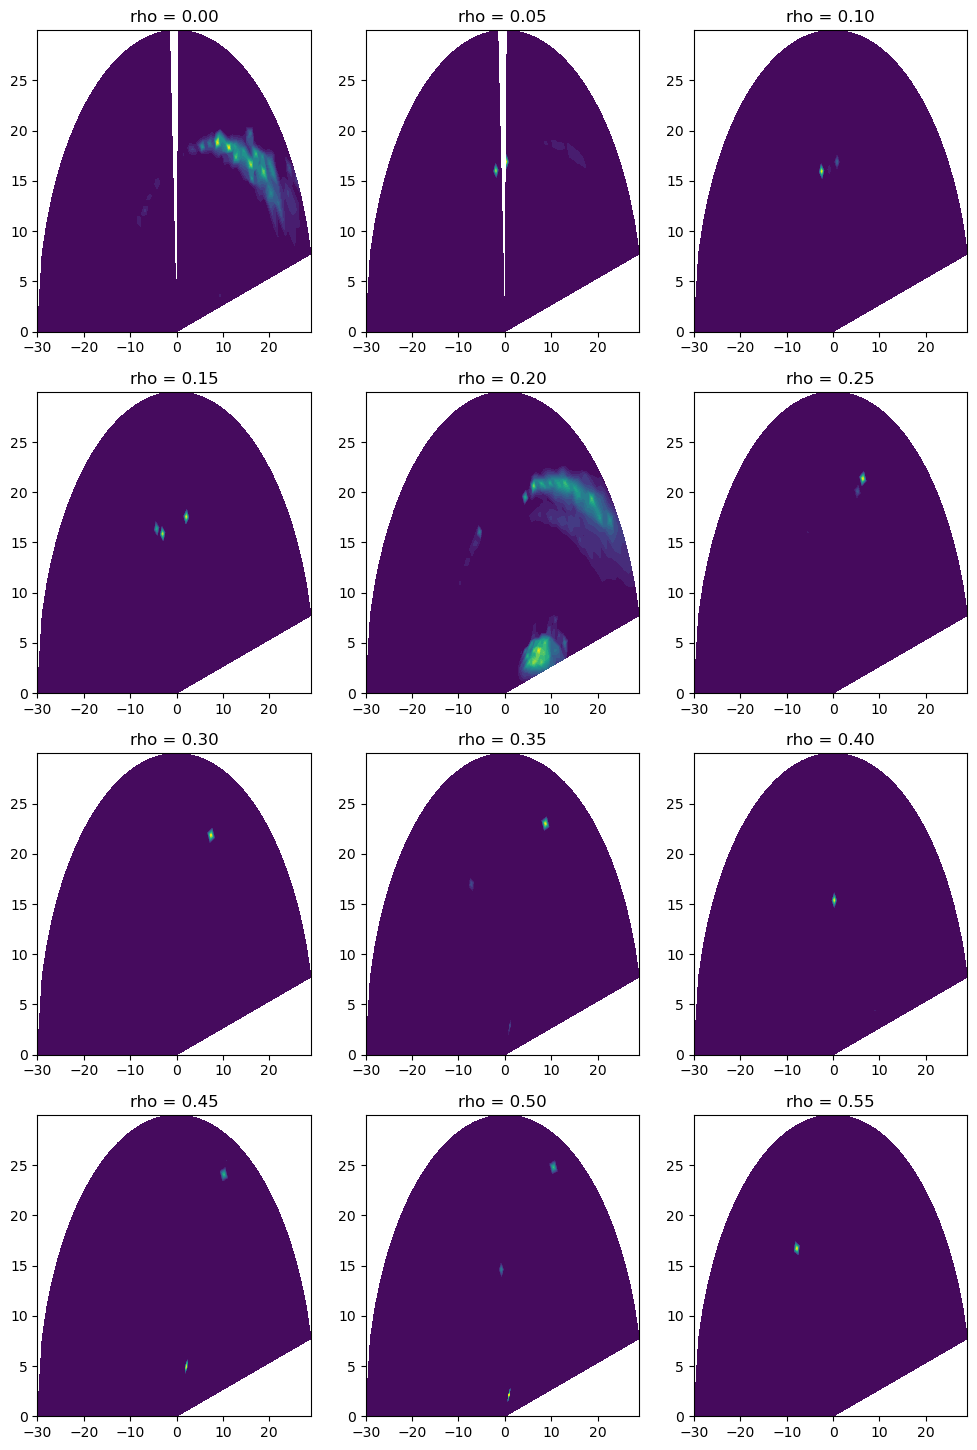

In [14]:
Pw, Kh = np.meshgrid(p_norm, ksi[:-1])

PP, PPer = Pw * Kh, Pw * np.sqrt(1 - Kh**2)

fig, axs = plt.subplots(4, 3, figsize=(12, 18))

for i, ax in enumerate(axs.flatten()):
    ax.contourf(PP, PPer, DRF0_wh[2*i].T, levels=20)
    ax.set_title(f'rho = {rho[2*i]:.2f}')

In [ ]:
D_rf_wh = np.sum(D_rf_nobounce_wh, axis=(1))

p_norm_h = 0.5 * (p_norm[1:] + p_norm[:-1])
ksi_h = 0.5 * (ksi[1:] + ksi[:-1])

P_norm, Ksi = np.meshgrid(p_norm, ksi_h)

PPar, PPerp = P_norm * Ksi, P_norm * np.sqrt(1 - Ksi**2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

c = axs[0].imshow(D_rf_wh[5, :,:].T)
axs[0].set_xlabel('p index')
axs[0].set_ylabel('ksi index')

d = axs[1].contourf(PPar, PPerp, D_rf_wh[5, :,:].T, 100)
axs[1].set_aspect('equal')


In [ ]:
with h5py.File('QL_bounce_temp.h5', 'w') as file:
    file.create_dataset('QL_bounce', data=D_rf_wh)
    file.create_dataset('RHO', data=rho)
    file.create_dataset('theta', data=theta)
    file.create_dataset('ksi', data=ksi)
    file.create_dataset('p_norm', data=p_norm)
    file.create_dataset('FreqGHz', data=FreqGHz)
    file.create_dataset('mode', data=mode)